# Proyecto final - parte 2

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as k
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Conjunto de datos

In [2]:
def load_image( infilename ) :
    img = Image.open( '/floyd/input/pvqm_db/distorted_images/' + infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [3]:
from os import listdir
from os.path import isfile, join
path = '/floyd/input/pvqm_db/distorted_images'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

imageDataset = []
index = 0
for imagePath in onlyfiles:
    image = load_image(imagePath)
    imageDataset.append(image)
    index += 1
imageDataset = np.asarray(imageDataset)

In [4]:
dataset2File = "dataset.csv"
dataFrame = pd.read_csv(dataset2File, sep = ';',header = 0)
mos = dataFrame['MOS-STD']

## Preprocesamiento de los datos

(384, 512, 3)
(384, 512, 3)
(384, 512, 3)
(384, 512, 3)
(384, 512, 3)


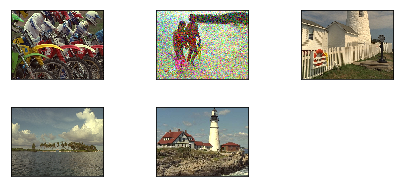

In [5]:
#visualising first 9 data from training dataset

fig = plt.figure()
for i in range(5):
    print(imageDataset[1].shape)
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(imageDataset[i])
    plt.xticks([])
    plt.yticks([])
#fig

In [6]:
#input image size 28*28
img_rows , img_cols = 384, 512
depth = 3

#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).

if k.image_data_format() == 'channels_first':
    print('channels first')
    imageDataset = imageDataset.reshape(imageDataset.shape[0], depth, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    print('channel last')
    imageDataset = imageDataset.reshape(imageDataset.shape[0], img_rows, img_cols, depth)
    input_shape = (img_rows, img_cols, depth)

#more reshaping
imageDataset = imageDataset.astype('float32')
imageDataset /= 255
print('imageDataset shape:', imageDataset.shape)
print(imageDataset.shape[0], 'imageDataset samples')

channel last
imageDataset shape: (1700, 384, 512, 3)
1700 imageDataset samples


In [7]:
split = train_test_split(mos, imageDataset, test_size=0.25, random_state=42)
(Y_train, Y_test, X_train, X_test) = split

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

1275 train samples
425 test samples


## Red neuronal CNN

In [8]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model



# Custom metric of Determination R2
def coeff_determination(y_true, y_pred):
    SS_res =  k.sum(k.square( y_true-y_pred )) 
    SS_tot = k.sum(k.square( y_true - k.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + k.epsilon()) )

model = create_cnn(img_cols, img_rows, depth, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics=[coeff_determination])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 384, 512, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 384, 512, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 384, 512, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 192, 256, 32)      4640      
_________________________________________________________________
activation_2 (Activation)    (None, 192, 256, 32)      0         
__________

## Entrenamiento del modelo

In [9]:
import time

batch_size = 8
num_epoch = 800

#model training

start = time.time()

model_log = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=0,
          validation_data=(X_test, Y_test))

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)

print(f"Training time: {m} min / {s} sec")

Training time: 210.98 min / 12658.81 sec


## Evaluación del rendimiento del CNN

In [10]:
#how well did it do? 

start = time.time()

score = model.evaluate(X_test, Y_test, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

print(f"Test time: {m} min / {s} sec")

Test loss: 165763.70239616843
Test accuracy: -1124.8046991684857 %
Test time: 0.04 min / 2.31 sec


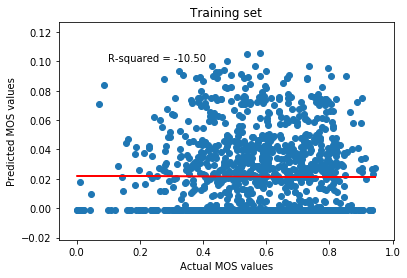

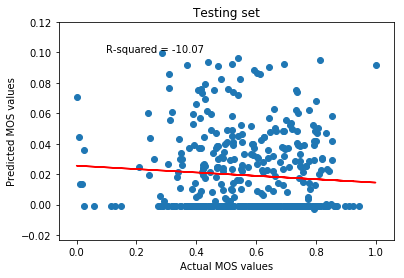

In [13]:
from sklearn.metrics import r2_score

def plot_metric(group, output, title):
    y_test = output.values
    Y_pred = model.predict(group)

    r_squared = r2_score(y_test, Y_pred)
    plt.scatter(y_test,Y_pred)
    plt.title(title)
    plt.xlabel('Actual MOS values')
    plt.ylabel('Predicted MOS values')

    denominator = y_test.dot(y_test) - y_test.mean() * y_test.sum()
    m = (y_test.dot(Y_pred) - Y_pred.mean() * y_test.sum()) / denominator
    b = (Y_pred.mean() * y_test.dot(y_test) - y_test.mean() * y_test.dot(Y_pred)) / denominator
    y_poly = m*y_test + b
    plt.plot(y_test, y_poly, 'r')
    plt.text(0.1, 0.1, 'R-squared = %0.2f' % r_squared)
    plt.show()
    
plot_metric(X_train, Y_train, 'Training set')
plot_metric(X_test, Y_test, 'Testing set')

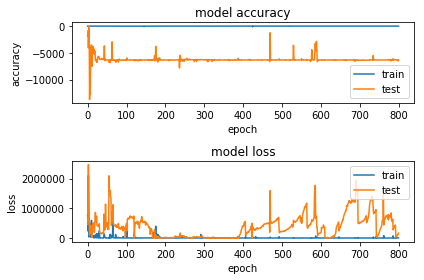

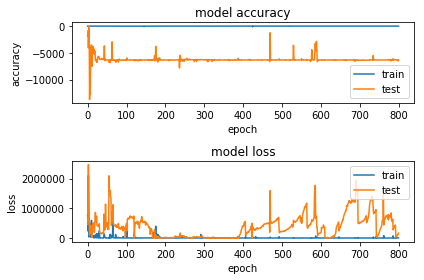

In [12]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['coeff_determination'])
plt.plot(model_log.history['val_coeff_determination'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [14]:
print(model_log.history['coeff_determination'])

[-31.69562562979904, -23.11698921203613, -19.182016611660227, -16.867169726315666, -16.741643971461876, -15.478540801253974, -16.079795114105824, -14.752564512514601, -13.277513494304582, -13.844118721905877, -13.152812424454035, -16.66104207506367, -16.10738467496984, -15.036244438021791, -14.739013711143942, -14.795599751565971, -13.487435975168266, -17.758634668986, -18.254737657285204, -18.236894450468174, -18.743894343656653, -18.989536430508483, -17.31613188350902, -17.691775078866996, -20.501331104951745, -20.032822648590685, -21.92205446879069, -20.82736286088532, -20.58089241775812, -19.373500339283662, -19.72040180729885, -23.51619675542794, -24.499286181879977, -21.571267846799365, -21.05799934387207, -22.202033981622435, -23.19138998143813, -21.61243687947591, -22.709690225638596, -19.59917669950747, -19.635599155800016, -21.89598539315018, -22.707818463456398, -24.8120948417514, -25.182469697840073, -26.748195106655945, -27.785043861538757, -28.551846874461454, -25.5054430